In [1]:
import mido
import numpy as np
import matplotlib.pyplot as plt
import PreProcessor as pp
import utils as ut

In [2]:
from keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, GRU, Dense, Lambda, Softmax, Activation, concatenate
from keras import optimizers
import tensorflow as tf

In [3]:
#dataset = pp.load_dataset("../adl-piano-midi")
dataset = pp.load_dataset("C:/Users/mxrin/OneDrive/Documents/KTH_2/DD2424/Projet/DD2424-MusicGen/adl-piano-midi")
ClassicSongs = pp.files_to_songs(dataset["Classical"])

channel_to_ind, ind_to_channel, note_to_ind, ind_to_note, velocity_to_ind, ind_to_velocity = pp.dicts_from_songs(ClassicSongs)
time_range = pp.ranges_from_songs(ClassicSongs)

n_Channels = len(channel_to_ind)
n_Notes = len(note_to_ind)
n_Velocities = len(velocity_to_ind)

print("\nNumber of channels   :",n_Channels,"\nNumber of notes      :",n_Notes,"\nNumber of velocities :",n_Velocities,"\nTime range           :",time_range[0],time_range[1])


Number of channels   : 12 
Number of notes      : 105 
Number of velocities : 128 
Time range           : 0.0 190.285


In [4]:
seq_length = 30
n_batch = 200

X_Channels, X_Notes, X_Velocities, X_Times, y_Channels, y_Notes, y_Velocities, y_Times, Val_X_Channels, Val_X_Notes, Val_X_Velocities, Val_X_Times, Val_y_Channels, Val_y_Notes, Val_y_Velocities, Val_y_Times, Test_X_Channels, Test_X_Notes, Test_X_Velocities, Test_X_Times, Test_y_Channels, Test_y_Notes, Test_y_Velocities, Test_y_Times = ut.prep_data(seq_length,ClassicSongs,n_Channels,n_Notes,n_Velocities,channel_to_ind,note_to_ind,velocity_to_ind,val_split=0.1,test_split=0.1)

In [5]:
print(X_Channels.shape)
print(X_Notes.shape)
print(X_Velocities.shape)
print(X_Times.shape)
print(Val_X_Times.shape)
print(Test_X_Times.shape)

(56724, 30, 12)
(56724, 30, 105)
(56724, 30, 128)
(56724, 30, 1)
(7090, 30, 1)
(7090, 30, 1)


In [6]:
dim = 300
learning_rate = 0.001

optimizer = optimizers.Adam(learning_rate=learning_rate)


lossRNN, lossGRU3 = [], []
channels_accuracyRNN, channels_accuracyGRU3 = [], []
notes_accuracyRNN, notes_accuracyGRU3 = [], []
velocities_accuracyRNN, velocities_accuracyGRU3 = [], []
times_accuracyRNN, times_accuracyGRU3 = [], []

val_lossRNN, val_lossGRU3 = [], []
val_channels_accuracyRNN, val_channels_accuracyGRU3 = [], []
val_notes_accuracyRNN, val_notes_accuracyGRU3 = [], []
val_velocities_accuracyRNN, val_velocities_accuracyGRU3 = [], []
val_times_accuracyRNN, val_times_accuracyGRU3 = [], []


losses = {
    'Channels': 'categorical_crossentropy',
    'Notes': 'categorical_crossentropy',
    'Velocities': 'categorical_crossentropy',
    'Times': 'mean_squared_error'
}


loss_weights = {
    'Channels': 0.25,
    'Notes': 5.0,
    'Velocities': 1.0,
    'Times': 1e-6
}

metrics = {
    'Channels': 'accuracy',
    'Notes': 'accuracy',
    'Velocities': 'accuracy',
    'Times': ut.tol_accuracy
}

GRU2_model = ut.create_model("GRU",[100,100],n_Channels,n_Notes,n_Velocities,time_range)
GRU2_model.summary()

Model: "GRU_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 12)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 105)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None, 128)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                          

In [7]:
n_epochs = 20

lossGRU2, channels_accuracyGRU2, notes_accuracyGRU2, velocities_accuracyGRU2, times_accuracyGRU2 = [], [], [], [], []
val_lossGRU2, val_channels_accuracyGRU2, val_notes_accuracyGRU2, val_velocities_accuracyGRU2, val_times_accuracyGRU2 = [], [], [], [], []

GRU2_model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)

In [8]:
del ClassicSongs

In [9]:
history = GRU2_model.fit([X_Channels, X_Notes, X_Velocities, X_Times], [y_Channels, y_Notes, y_Velocities, y_Times], epochs=n_epochs, batch_size=n_batch, validation_data=([Val_X_Channels, Val_X_Notes, Val_X_Velocities, Val_X_Times], [Val_y_Channels, Val_y_Notes, Val_y_Velocities, Val_y_Times]))
lossGRU2 += history.history['loss']
channels_accuracyGRU2 += history.history['Channels_accuracy']
notes_accuracyGRU2 += history.history['Notes_accuracy']
velocities_accuracyGRU2 += history.history['Velocities_accuracy']
times_accuracyGRU2 += history.history['Times_tol_accuracy']
val_lossGRU2 += history.history['val_loss']
val_channels_accuracyGRU2 += history.history['val_Channels_accuracy']
val_notes_accuracyGRU2 += history.history['val_Notes_accuracy']
val_velocities_accuracyGRU2 += history.history['val_Velocities_accuracy']
val_times_accuracyGRU2 += history.history['val_Times_tol_accuracy']


Epoch 1/20
284/284 [==============================] - 81s 254ms/step - loss: 21.4300 - Channels_loss: 0.8018 - Notes_loss: 3.7354 - Velocities_loss: 2.5517 - Times_loss: 644.7852 - Channels_accuracy: 0.7034 - Notes_accuracy: 0.0712 - Velocities_accuracy: 0.5681 - Times_tol_accuracy: 8.8028e-06 - val_loss: 18.9368 - val_Channels_loss: 0.6970 - val_Notes_loss: 3.2996 - val_Velocities_loss: 2.2644 - val_Times_loss: 52.5040 - val_Channels_accuracy: 0.7083 - val_Notes_accuracy: 0.1257 - val_Velocities_accuracy: 0.5987 - val_Times_tol_accuracy: 1.3889e-05
Epoch 2/20
284/284 [==============================] - 85s 298ms/step - loss: 18.1042 - Channels_loss: 0.6205 - Notes_loss: 3.1533 - Velocities_loss: 2.1825 - Times_loss: 41.4078 - Channels_accuracy: 0.7257 - Notes_accuracy: 0.1553 - Velocities_accuracy: 0.6088 - Times_tol_accuracy: 3.2864e-05 - val_loss: 17.6211 - val_Channels_loss: 0.5859 - val_Notes_loss: 3.0684 - val_Velocities_loss: 2.1324 - val_Times_loss: 34.7120 - val_Channels_accura

In [12]:
##save model
GRU2_model.save("GRU2_model.h5")

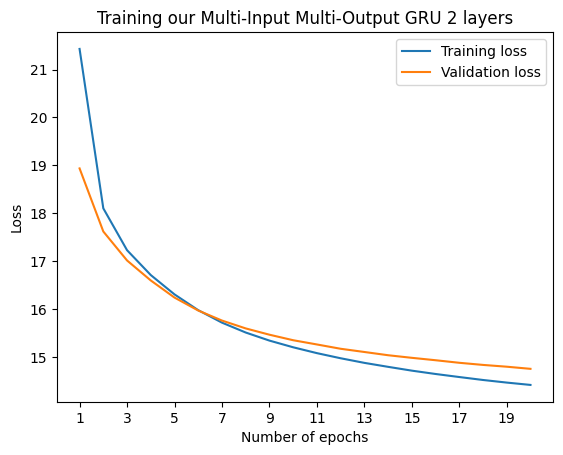

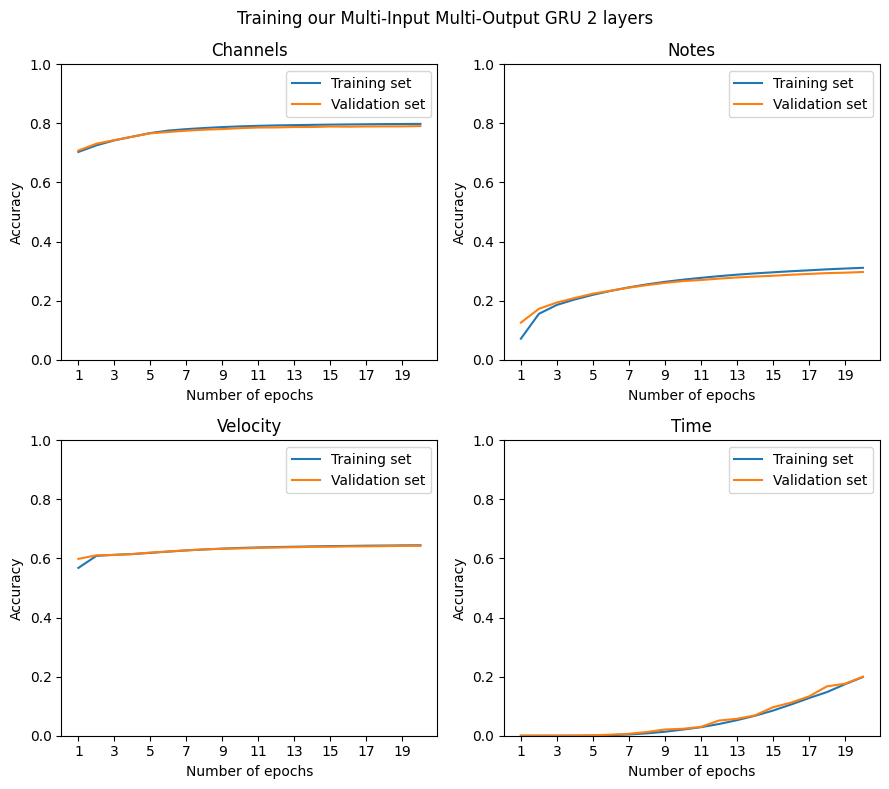

In [11]:
ut.plot_training_results("Training our Multi-Input Multi-Output GRU 2 layers",lossGRU2,channels_accuracyGRU2,notes_accuracyGRU2,velocities_accuracyGRU2,times_accuracyGRU2,val_lossGRU2,val_channels_accuracyGRU2,val_notes_accuracyGRU2,val_velocities_accuracyGRU2,val_times_accuracyGRU2)

In [14]:
lossLSTM = []
channels_accuracyLSTM = []
notes_accuracyLSTM = []
velocities_accuracyLSTM = []
times_accuracyLSTM = []

val_lossLSTM = []
val_channels_accuracyLSTM = []
val_notes_accuracyLSTM = []
val_velocities_accuracyLSTM = []
val_times_accuracyLSTM = []

LSTM4_model = ut.create_model("LSTM",[100,100,100,100],n_Channels,n_Notes,n_Velocities,time_range)
LSTM4_model.summary()

Model: "LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, None, 12)]   0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, None, 105)]  0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, None, 128)]  0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, None, 1)]    0           []                               
                                                                                         

In [15]:
n_epochs = 20

LSTM4_model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)
history = LSTM4_model.fit([X_Channels, X_Notes, X_Velocities, X_Times], [y_Channels, y_Notes, y_Velocities, y_Times], epochs=n_epochs, batch_size=n_batch, validation_data=([Val_X_Channels, Val_X_Notes, Val_X_Velocities, Val_X_Times], [Val_y_Channels, Val_y_Notes, Val_y_Velocities, Val_y_Times]))


Epoch 1/20
284/284 [==============================] - 139s 439ms/step - loss: 22.6580 - Channels_loss: 0.8654 - Notes_loss: 3.9675 - Velocities_loss: 2.6033 - Times_loss: 644.7753 - Channels_accuracy: 0.6966 - Notes_accuracy: 0.0371 - Velocities_accuracy: 0.5555 - Times_tol_accuracy: 1.4671e-05 - val_loss: 22.2449 - val_Channels_loss: 0.7804 - val_Notes_loss: 3.9280 - val_Velocities_loss: 2.4100 - val_Times_loss: 17.2622 - val_Channels_accuracy: 0.6978 - val_Notes_accuracy: 0.0372 - val_Velocities_accuracy: 0.5702 - val_Times_tol_accuracy: 1.8519e-05
Epoch 2/20
284/284 [==============================] - 119s 420ms/step - loss: 22.1908 - Channels_loss: 0.7711 - Notes_loss: 3.9215 - Velocities_loss: 2.3903 - Times_loss: 9.6493 - Channels_accuracy: 0.6995 - Notes_accuracy: 0.0378 - Velocities_accuracy: 0.5750 - Times_tol_accuracy: 8.0399e-05 - val_loss: 22.2168 - val_Channels_loss: 0.7793 - val_Notes_loss: 3.9259 - val_Velocities_loss: 2.3923 - val_Times_loss: 5.7766 - val_Channels_accura

KeyError: 'Velocities_rounded_accuracy'

In [ ]:
lossLSTM += history.history['loss']
channels_accuracyLSTM += history.history['Channels_accuracy']
notes_accuracyLSTM += history.history['Notes_accuracy']

In [16]:
velocities_accuracyLSTM += history.history['Velocities_accuracy']
times_accuracyLSTM += history.history['Times_tol_accuracy']

val_lossLSTM += history.history['val_loss']
val_channels_accuracyLSTM += history.history['val_Channels_accuracy']
val_notes_accuracyLSTM += history.history['val_Notes_accuracy']
val_velocities_accuracyLSTM += history.history['val_Velocities_accuracy']
val_times_accuracyLSTM += history.history['val_Times_tol_accuracy']

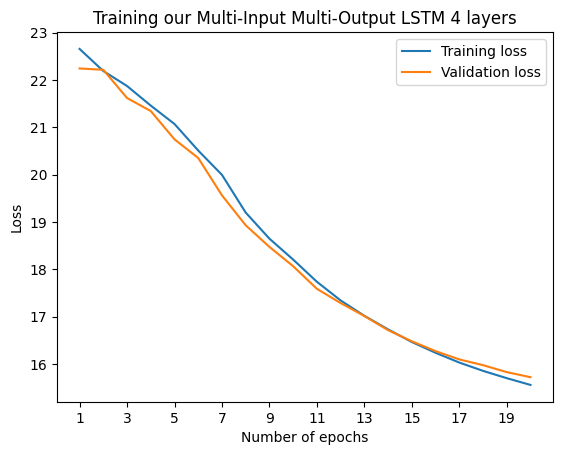

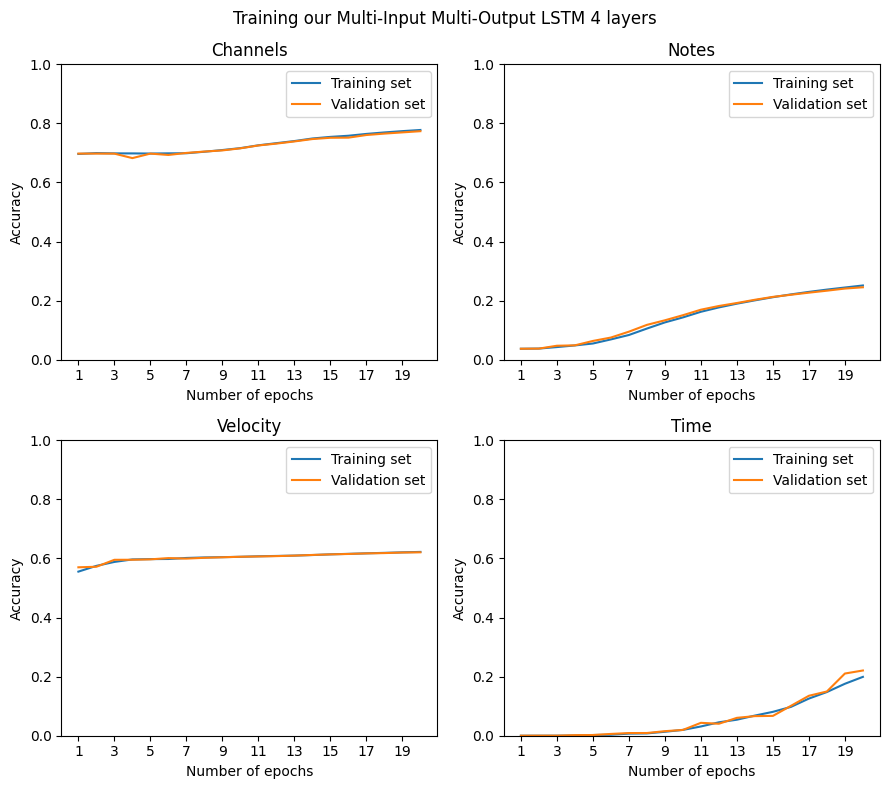

In [17]:
ut.plot_training_results("Training our Multi-Input Multi-Output LSTM 4 layers",lossLSTM,channels_accuracyLSTM,notes_accuracyLSTM,velocities_accuracyLSTM,times_accuracyLSTM,val_lossLSTM,val_channels_accuracyLSTM,val_notes_accuracyLSTM,val_velocities_accuracyLSTM,val_times_accuracyLSTM)

In [18]:
##save model
#LSTM4_model.save("LSTM4_model.h5")

In [23]:
dim = 300
learning_rate = 0.001
optimizer = optimizers.Adam(learning_rate=learning_rate)
n_epochs = 20

lossGRU4, channels_accuracyGRU4, notes_accuracyGRU4, velocities_accuracyGRU4, times_accuracyGRU4 = [], [], [], [], []
val_lossGRU4, val_channels_accuracyGRU4, val_notes_accuracyGRU4, val_velocities_accuracyGRU4, val_times_accuracyGRU4 = [], [], [], [], [] 

GRU4_model = ut.create_model("GRU",[100,100,100,100],n_Channels,n_Notes,n_Velocities,time_range)
GRU4_model.summary()

Model: "GRU_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, None, 12)]   0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, None, 105)]  0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, None, 128)]  0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, None, 1)]    0           []                               
                                                                                          

In [25]:
GRU4_model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)
history = GRU4_model.fit([X_Channels, X_Notes, X_Velocities, X_Times], [y_Channels, y_Notes, y_Velocities, y_Times], epochs=n_epochs, batch_size=n_batch, validation_data=([Val_X_Channels, Val_X_Notes, Val_X_Velocities, Val_X_Times], [Val_y_Channels, Val_y_Notes, Val_y_Velocities, Val_y_Times]))

lossGRU4 += history.history['loss']
channels_accuracyGRU4 += history.history['Channels_accuracy']
notes_accuracyGRU4 += history.history['Notes_accuracy']
velocities_accuracyGRU4 += history.history['Velocities_accuracy']
times_accuracyGRU4 += history.history['Times_tol_accuracy']
val_lossGRU4 += history.history['val_loss']
val_channels_accuracyGRU4 += history.history['val_Channels_accuracy']
val_notes_accuracyGRU4 += history.history['val_Notes_accuracy']
val_velocities_accuracyGRU4 += history.history['val_Velocities_accuracy']
val_times_accuracyGRU4 += history.history['val_Times_tol_accuracy']

Epoch 1/20
284/284 [==============================] - 148s 467ms/step - loss: 22.1602 - Channels_loss: 0.8309 - Notes_loss: 3.8883 - Velocities_loss: 2.5107 - Times_loss: 360.9516 - Channels_accuracy: 0.6960 - Notes_accuracy: 0.0443 - Velocities_accuracy: 0.5581 - Times_tol_accuracy: 3.0516e-05 - val_loss: 21.5479 - val_Channels_loss: 0.7765 - val_Notes_loss: 3.8077 - val_Velocities_loss: 2.3153 - val_Times_loss: 11.0665 - val_Channels_accuracy: 0.6824 - val_Notes_accuracy: 0.0498 - val_Velocities_accuracy: 0.5906 - val_Times_tol_accuracy: 1.3889e-05
Epoch 2/20
284/284 [==============================] - 133s 469ms/step - loss: 20.8769 - Channels_loss: 0.7599 - Notes_loss: 3.6799 - Velocities_loss: 2.2875 - Times_loss: 38.9413 - Channels_accuracy: 0.6949 - Notes_accuracy: 0.0639 - Velocities_accuracy: 0.5942 - Times_tol_accuracy: 0.0082 - val_loss: 19.9462 - val_Channels_loss: 0.7762 - val_Notes_loss: 3.4958 - val_Velocities_loss: 2.2731 - val_Times_loss: 55.7108 - val_Channels_accuracy

In [27]:
##save the model
GRU4_model.save("GRU4_model.h5")

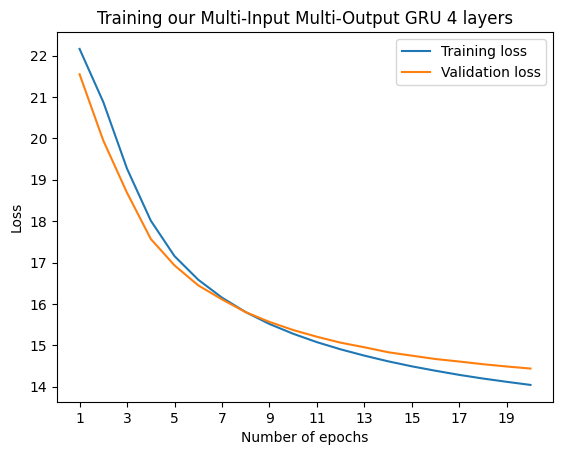

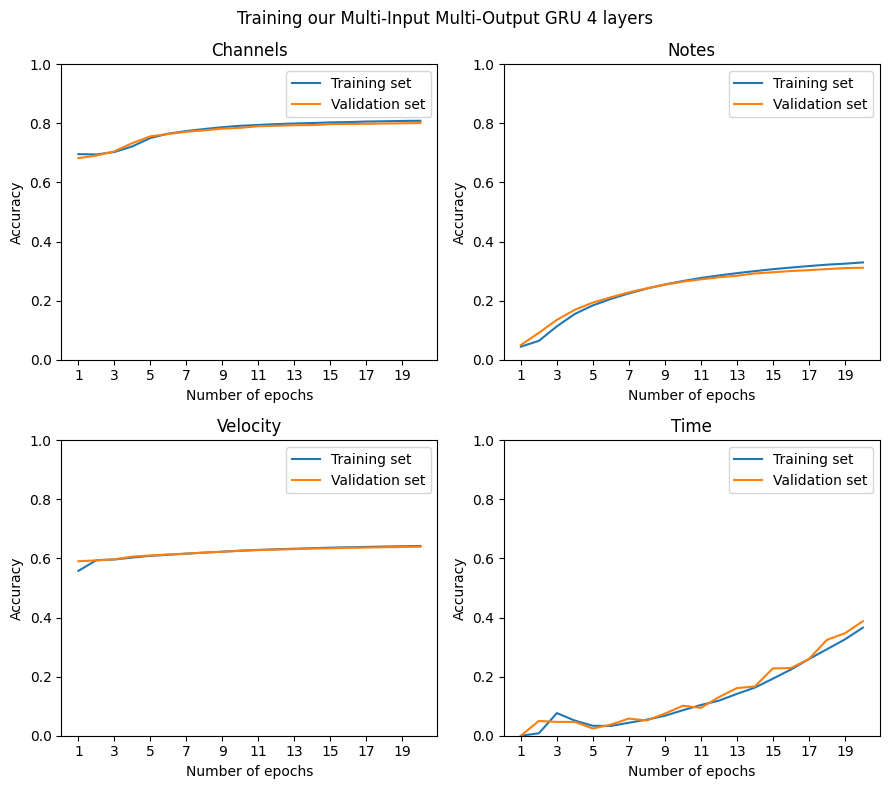

In [26]:
ut.plot_training_results("Training our Multi-Input Multi-Output GRU 4 layers",lossGRU4,channels_accuracyGRU4,notes_accuracyGRU4,velocities_accuracyGRU4,times_accuracyGRU4,val_lossGRU4,val_channels_accuracyGRU4,val_notes_accuracyGRU4,val_velocities_accuracyGRU4,val_times_accuracyGRU4)

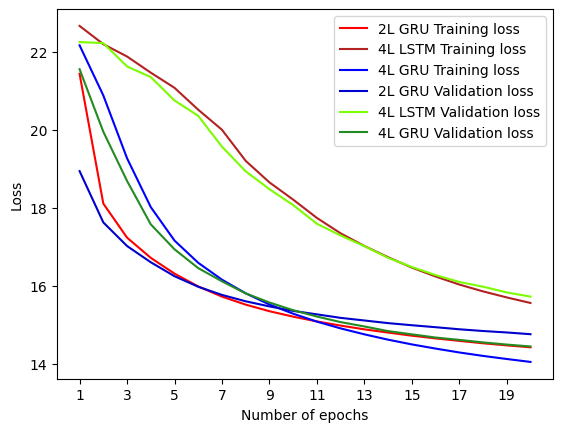

In [34]:
n = len(lossGRU4)+1
x = range(1,n)
x_ticks = range(1,n,max(1,n//10))

plt.figure()
plt.plot(x, lossGRU2, label="2L GRU Training loss",color='red')
plt.plot(x, lossLSTM, label="4L LSTM Training loss",color='firebrick')
plt.plot(x, lossGRU4, label="4L GRU Training loss",color='blue')
plt.plot(x, val_lossGRU2, label="2L GRU Validation loss",color='mediumblue')
plt.plot(x, val_lossLSTM, label="4L LSTM Validation loss",color='lawngreen')
plt.plot(x, val_lossGRU4, label="4L GRU Validation loss",color='forestgreen')
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.xticks(x_ticks)
plt.show()

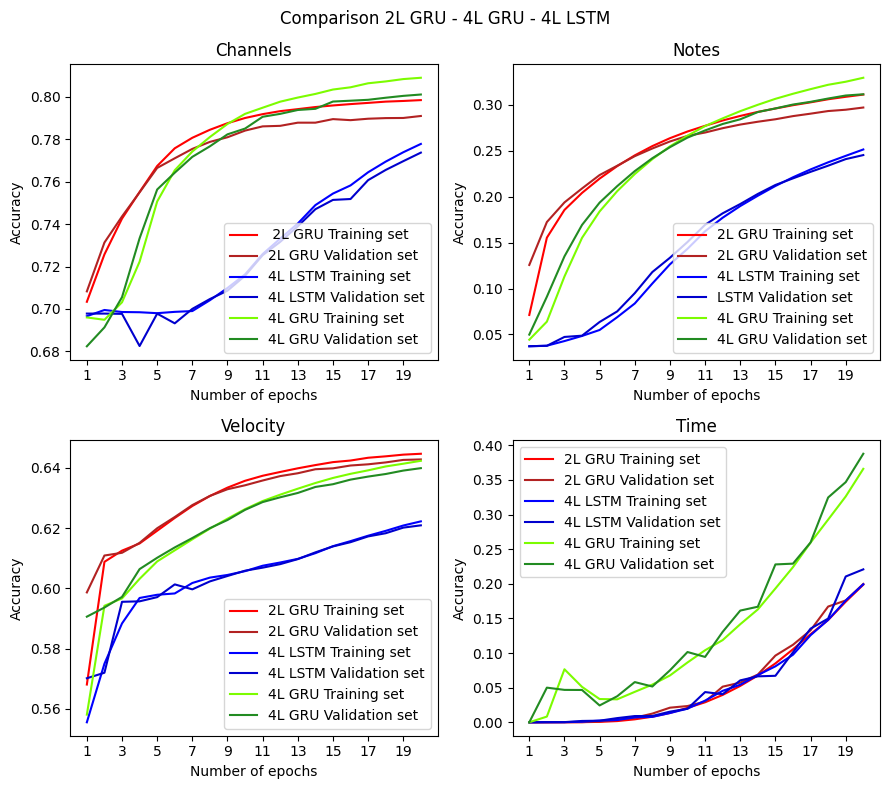

In [30]:
x = range(1,n)
x_ticks = range(1,n,max(1,n//10))

fig, axs = plt.subplots(2, 2, figsize=(9, 8))

axs[0,0].plot(x, channels_accuracyGRU2, label=" 2L GRU Training set",color='red')
axs[0,0].plot(x, val_channels_accuracyGRU2, label="2L GRU Validation set",color='firebrick')
axs[0,0].plot(x, channels_accuracyLSTM, label="4L LSTM Training set",color='blue')
axs[0,0].plot(x, val_channels_accuracyLSTM, label="4L LSTM Validation set",color='mediumblue')
axs[0,0].plot(x, channels_accuracyGRU4, label="4L GRU Training set",color='lawngreen')
axs[0,0].plot(x, val_channels_accuracyGRU4, label="4L GRU Validation set",color='forestgreen')
axs[0,0].legend()
#axs[0,0].set_ylim([0,1])
axs[0,0].set_title("Channels")
axs[0,0].set_xlabel("Number of epochs")
axs[0,0].set_ylabel("Accuracy")
axs[0,0].set_xticks(x_ticks)

axs[0,1].plot(x, notes_accuracyGRU2, label="2L GRU Training set",color='red')
axs[0,1].plot(x, val_notes_accuracyGRU2, label="2L GRU Validation set",color='firebrick')
axs[0,1].plot(x, notes_accuracyLSTM, label="4L LSTM Training set",color='blue')
axs[0,1].plot(x, val_notes_accuracyLSTM, label="LSTM Validation set",color='mediumblue')
axs[0,1].plot(x, notes_accuracyGRU4, label="4L GRU Training set",color='lawngreen')
axs[0,1].plot(x, val_notes_accuracyGRU4, label="4L GRU Validation set",color='forestgreen')
axs[0,1].legend()
#axs[0,1].set_ylim([0,1])
axs[0,1].set_title("Notes")
axs[0,1].set_xlabel("Number of epochs")
axs[0,1].set_ylabel("Accuracy")
axs[0,1].set_xticks(x_ticks)



axs[1,0].plot(x, velocities_accuracyGRU2, label="2L GRU Training set",color='red')
axs[1,0].plot(x, val_velocities_accuracyGRU2, label="2L GRU Validation set",color='firebrick')
axs[1,0].plot(x, velocities_accuracyLSTM, label="4L LSTM Training set",color='blue')
axs[1,0].plot(x, val_velocities_accuracyLSTM, label="4L LSTM Validation set",color='mediumblue')
axs[1,0].plot(x, velocities_accuracyGRU4, label="4L GRU Training set",color='lawngreen')
axs[1,0].plot(x, val_velocities_accuracyGRU4, label="4L GRU Validation set",color='forestgreen')
axs[1,0].legend()
#axs[1,0].set_ylim([0,1])
axs[1,0].set_title("Velocity")
axs[1,0].set_xlabel("Number of epochs")
axs[1,0].set_ylabel("Accuracy")
axs[1,0].set_xticks(x_ticks)

axs[1,1].plot(x, times_accuracyGRU2, label="2L GRU Training set",color='red')
axs[1,1].plot(x, val_times_accuracyGRU2, label="2L GRU Validation set",color='firebrick')
axs[1,1].plot(x, times_accuracyLSTM, label="4L LSTM Training set",color='blue')
axs[1,1].plot(x, val_times_accuracyLSTM, label="4L LSTM Validation set",color='mediumblue')
axs[1,1].plot(x, times_accuracyGRU4, label="4L GRU Training set",color='lawngreen')
axs[1,1].plot(x, val_times_accuracyGRU4, label="4L GRU Validation set",color='forestgreen')

axs[1,1].legend()
#axs[1,1].set_ylim([0,1])
axs[1,1].set_title("Time")
axs[1,1].set_xlabel("Number of epochs")
axs[1,1].set_ylabel("Accuracy")
axs[1,1].set_xticks(x_ticks)

fig.suptitle("Comparison 2L GRU - 4L GRU - 4L LSTM")
fig.tight_layout(rect=[0, 0, 1, 1])

In [31]:
##save figure
#plt.savefig("Comparison_2L_GRU_4L_GRU_4L_LSTM.png")

<Figure size 640x480 with 0 Axes>

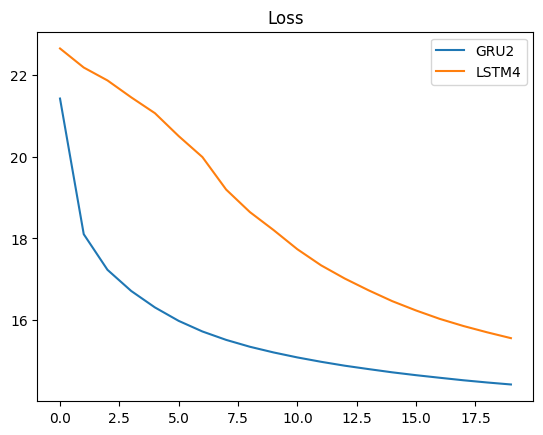

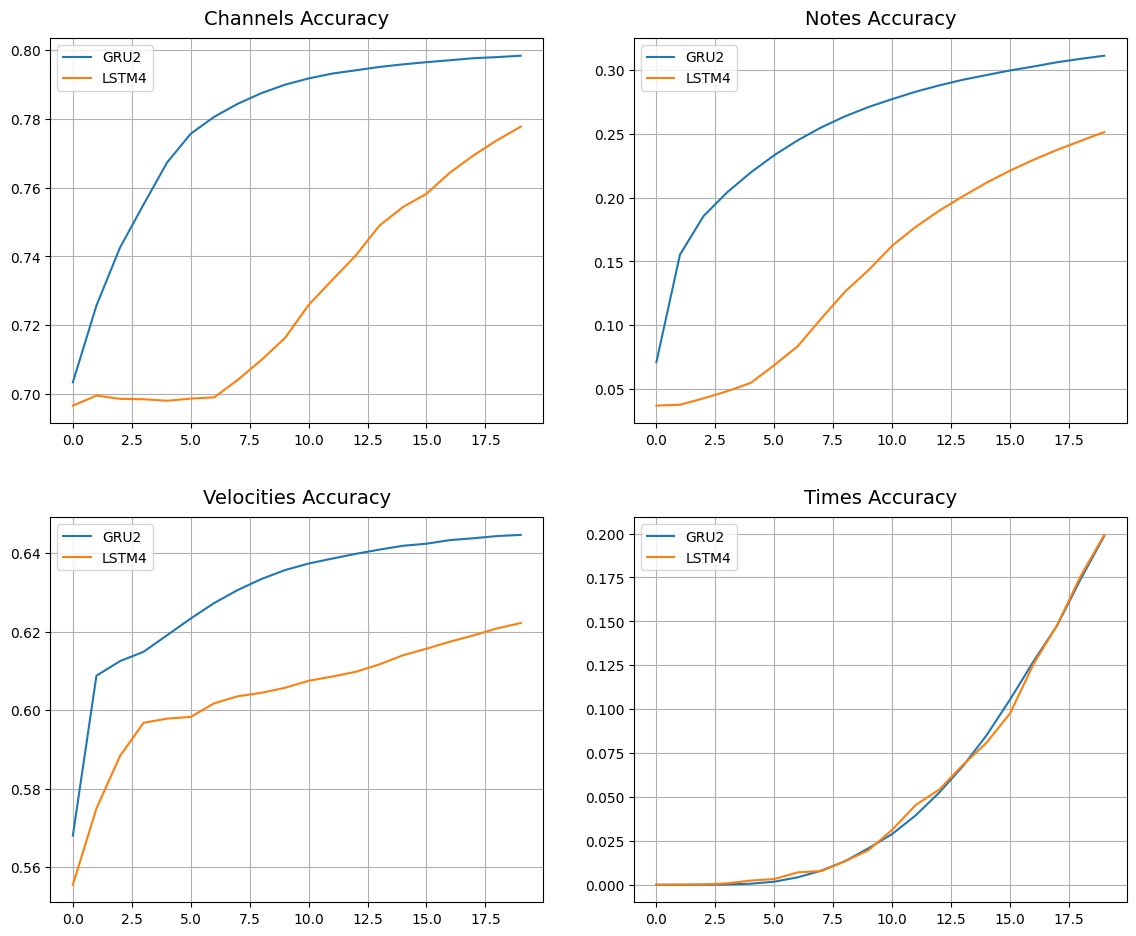

In [21]:
##PLot that compares GRU and LSTM on the same graph
plt.figure()
plt.plot(lossGRU2, label='GRU2')
plt.plot(lossLSTM, label='LSTM4')
plt.title('Loss')
plt.legend()
plt.show()

##Plot the accuracys on the same figure
plt.figure(figsize=(12, 10))  # Increase the size for better visibility

# Define the first subplot
plt.subplot(2, 2, 1)
plt.plot(channels_accuracyGRU2, label='GRU2')
plt.plot(channels_accuracyLSTM, label='LSTM4')
plt.plot(channels_accuracyGRU4, label='GRU4')
plt.title('Channels Accuracy', fontsize=14, pad=10)  # Increase font size and add padding
plt.legend()
plt.grid(True)

# Define the second subplot
plt.subplot(2, 2, 2)
plt.plot(notes_accuracyGRU2, label='GRU2')
plt.plot(notes_accuracyLSTM, label='LSTM4')
plt.plot(notes_accuracyGRU4, label='GRU4')
plt.title('Notes Accuracy', fontsize=14, pad=10)  # Increase font size and add padding
plt.legend()
plt.grid(True)

# Define the third subplot
plt.subplot(2, 2, 3)
plt.plot(velocities_accuracyGRU2, label='GRU2')
plt.plot(velocities_accuracyLSTM, label='LSTM4')
plt.plot(velocities_accuracyGRU4, label='GRU4')
plt.title('Velocities Accuracy', fontsize=14, pad=10)  # Increase font size and add padding
plt.legend()
plt.grid(True)

# Define the fourth subplot
plt.subplot(2, 2, 4)
plt.plot(times_accuracyGRU2, label='GRU2')
plt.plot(times_accuracyLSTM, label='LSTM4')
plt.plot(times_accuracyGRU4, label='GRU4')
plt.title('Times Accuracy', fontsize=14, pad=10)  # Increase font size and add padding
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout(pad=3.0)

# Show the plot
plt.show()

Generating music

In [35]:
gen = ut.generate(LSTM4_model,[X_Channels[2:3,:,:], X_Notes[2:3,:,:], X_Velocities[2:3,:,:], X_Times[2:3,:,:]],30,ind_to_channel,ind_to_note,mode="SoftMax",T=0.8)
gen


1/1 [==============================] - 0s 37ms/step


[[4, 69, 1, 0.4473246],
 [0, 80, 1, 1.058059],
 [0, 82, 1, 1.6072037],
 [0, 73, 1, 1.8531386],
 [0, 70, 1, 1.299011],
 [0, 59, 1, 1.4591408],
 [0, 57, 1, 1.9424026],
 [0, 62, 1, 1.9199915],
 [0, 65, 1, 1.9641354],
 [0, 64, 1, 1.9884428],
 [1, 67, 1, 1.5802562],
 [1, 56, 0, 1.2372576],
 [0, 62, 0, 0.72242534],
 [0, 65, 0, 0.9911164],
 [0, 68, 0, 1.0331897],
 [0, 70, 0, 0.7300582],
 [0, 52, 0, 0.8282611],
 [0, 57, 0, 0.6629354],
 [0, 61, 0, 1.0356954],
 [0, 56, 0, 0.9433645],
 [0, 52, 0, 0.76243275],
 [0, 40, 0, 0.657807],
 [0, 52, 0, 1.0180236],
 [1, 56, 0, 0.6753339],
 [0, 73, 0, 0.70168245],
 [0, 79, 0, 0.8151604],
 [2, 50, 0, 0.9993334],
 [1, 57, 0, 1.3806069],
 [0, 60, 0, 0.83870685],
 [0, 60, 0, 0.9957033]]

In [36]:
channels,notes,velocities,times = ut.create_midi(gen)
print(channels)
time_ = [int(l*120) for l in times]
print(notes)
print(velocities)
print(times)

[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0]
[69, 80, 82, 73, 70, 59, 57, 62, 65, 64, 67, 56, 62, 65, 68, 70, 52, 57, 61, 56, 52, 40, 52, 56, 73, 79, 50, 57, 60, 60]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.4473246, 1.058059, 1.6072037, 1.8531386, 1.299011, 1.4591408, 1.9424026, 1.9199915, 1.9641354, 1.9884428, 1.5802562, 1.2372576, 0.72242534, 0.9911164, 1.0331897, 0.7300582, 0.8282611, 0.6629354, 1.0356954, 0.9433645, 0.76243275, 0.657807, 1.0180236, 0.6753339, 0.70168245, 0.8151604, 0.9993334, 1.3806069, 0.83870685, 0.9957033]


In [38]:
from mido import Message, MetaMessage, MidiFile, MidiTrack, bpm2tempo, second2tick


In [39]:
mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)

track.append(MetaMessage('key_signature', key='Dm'))
#track.append(MetaMessage('set_tempo', tempo=bpm2tempo(960)))
track.append(MetaMessage('time_signature', numerator=6, denominator=8))

for i in range(len(channels)):
    track.append(Message('note_on', channel=channels[i], note=notes[i], velocity=velocities[i]+70, time=time_[i]))
track.append(MetaMessage('end_of_track'))
mid.save('new_song.mid')

In [41]:
import pygame
pygame.init()
pygame.mixer.music.load("new_song.mid")
pygame.mixer.music.play()